## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, Grayscale, RandomAdjustSharpness, Normalize
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.Transformer import *
from architecture.AutoEncoder import *

In [2]:
torch.manual_seed(109)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [4]:
def create_subsets(root, transformation):
    dataset = ImageFolder(root, transformation)
    train, test, val = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
    return train, test, val

In [5]:
def produce_loaders(train, test, val):
    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    valid_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = False)
    return train_loader, test_loader, valid_loader

In [6]:
size = 44
batch_size = 128
transformation = Compose([RandomHorizontalFlip(), Resize((size, size)), ToTensor()])

In [7]:
root = 'expanded_dataset/cropped_aug'
train_data, test_data, val_data = create_subsets(root, transformation)
train_loader, test_loader, val_loader = produce_loaders(train_data, test_data, val_data)

[1052, 7937, 1838, 7803, 5960, 501, 8102, 1934, 4330]


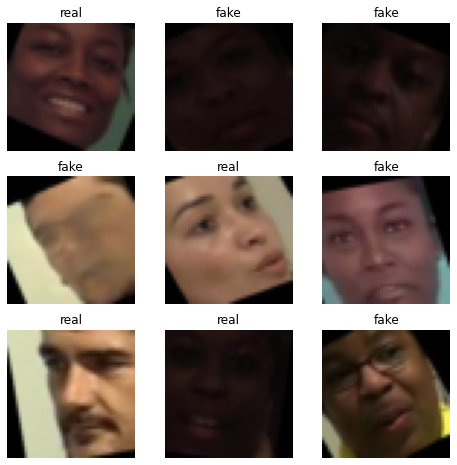

In [8]:
visualize_data(train_data)

[927, 33, 81, 161, 65, 356, 1025, 456, 265]


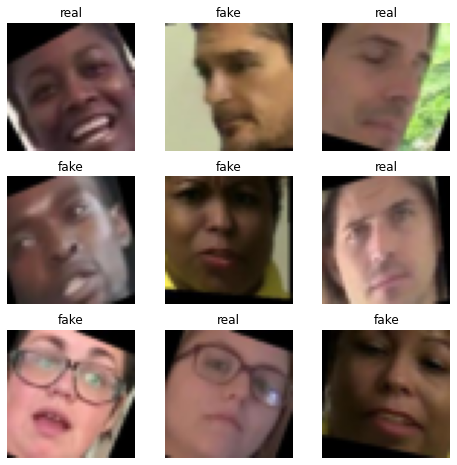

In [9]:
visualize_data(test_data)

## Load AutoEncoder

In [10]:
# number of hidden layers and their sizes
hidden_a = [3, 32, 64, 128, 256]

# kernel size of convolution layers
kernel_size_a = 3

In [11]:
autoencmodel = AutoEncoder(hidden_a, kernel_size_a).to(device)
autoencmodel.load_state_dict(torch.load("./autoencoder256_22epochs")["model_state_dict"])

<All keys matched successfully>

In [12]:
for param in autoencmodel.parameters():
    param.requiresGrad = False
print(autoencmodel)

AutoEncoder(
  (enc_combined): Sequential(
    (0): Encoder(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (1): Encoder(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (2): Encoder(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (3): Encoder(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
  )
  (dec_combined): Seq

## Initialise Model

Parameters that can be changed:

1) Kernel size

2) hidden - no. of neurons in each layer and no. of layers)

3) window - window size for max-pooling

4) blocks - no.of neurons in transformer block


In [13]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False,weight_decay=1e-5):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [16]:
from math import floor
# number of hidden layers and their sizes
hidden = [256, 256, 64, 32]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 3

# calculate final size of image
new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
channels = hidden[-1]
changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img
blocks = [flattened, 512, 64]

In [17]:
model = Transformer(hidden, kernel_size, window, blocks).to(device)
print(model)

Transformer(
  (conv_combined): Sequential(
    (0): ConvEmbed(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): ConvEmbed(
      (conv): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): ConvEmbed(
      (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (blocks_combined): Sequential(
    (0): TransformerBlock(
      (attention): AttentionLayer(
        (query): Linear(in_features=3200, out_fe

In [40]:
model2 = Transformer(hidden, kernel_size, window, blocks).to(device)
model2.load_state_dict(torch.load("./Transformer_checkpoint_withAE")["model_state_dict"])

<All keys matched successfully>

In [18]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [19]:
optimizer = create_adam_optimizer(model, lr = 0.001)

In [30]:
"""
train

Function used to train the model. Returns four lists for the purposes of plotting performance curves.

Parameters:
device - device to use
model - model to train
train_loader - training data loader
val_loader - validation data loader
optimizer - optimizer to use (allows for saving and reloading optimizer state to stop and resume training)
epochs - epochs to train the model
criterion - loss function to use (default is cross entropy)
patience - number of iterations validation loss is allowed to increase before training is stopped (default is 3)
autoencoder - autoencoder to use, if any (default is None)
checkpoint - if True, a checkpoint of the model (and optimizer) will saved if the model either has the current
             lowest validation loss, has a validation accuracy of at least 90%, or both (default is True)

Returns lists of the training loss, training accuracy, validation loss and validation accuracy for plotting curves.

"""
tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = 20, autoencoder=autoencmodel)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/20, Batch number: 0, Cumulated accuracy: 0.7265625
Epoch 1/20, Batch number: 5, Cumulated accuracy: 0.7200520833333334
Epoch 1/20, Batch number: 10, Cumulated accuracy: 0.7265625
Epoch 1/20, Batch number: 15, Cumulated accuracy: 0.72900390625
Epoch 1/20, Batch number: 20, Cumulated accuracy: 0.7321428571428571
Epoch 1/20, Batch number: 25, Cumulated accuracy: 0.7238581730769231
Epoch 1/20, Batch number: 30, Cumulated accuracy: 0.7260584677419355
Epoch 1/20, Batch number: 35, Cumulated accuracy: 0.7248263888888888
Epoch 1/20, Batch number: 40, Cumulated accuracy: 0.7227515243902439
Epoch 1/20, Batch number: 45, Cumulated accuracy: 0.7233355978260869
Epoch 1/20, Batch number: 50, Cumulated accuracy: 0.7233455882352942
Epoch 1/20, Batch number: 55, Cumulated accuracy: 0.7212611607142857
Epoch 1/20, Batch number: 60, Cumulated accuracy: 0.7224641393442623
--- Epoch 1/20: Train loss: 0.5691, Train accuracy: 0.7228
--- Epoch 1/20: Val loss: 0.4592, Val accuracy: 0.8396
Epoch 2/20, Ba

Epoch 9/20, Batch number: 25, Cumulated accuracy: 0.7403846153846154
Epoch 9/20, Batch number: 30, Cumulated accuracy: 0.7414314516129032
Epoch 9/20, Batch number: 35, Cumulated accuracy: 0.7395833333333334
Epoch 9/20, Batch number: 40, Cumulated accuracy: 0.7414253048780488
Epoch 9/20, Batch number: 45, Cumulated accuracy: 0.7420176630434783
Epoch 9/20, Batch number: 50, Cumulated accuracy: 0.7411151960784313
Epoch 9/20, Batch number: 55, Cumulated accuracy: 0.7412109375
Epoch 9/20, Batch number: 60, Cumulated accuracy: 0.7421875
--- Epoch 9/20: Train loss: 0.5356, Train accuracy: 0.7419
--- Epoch 9/20: Val loss: 0.4090, Val accuracy: 0.8802
Stopped early due to increasing validation loss.


## Testing Model & Performance Curves

In [31]:
"""
test

Function used to obtain the validation or test loss and accuracy of the model. Can also return
additional lists used for confusion matrix computation.

Parameters:
device - device to use
model - model to train
data_loader - chosen (testing) data loader
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)
get_predictions - if True, returns the list of true labels, the list of predictions made by the model, 
                  followed by values of the test loss and test accuracy (default is False)

By default, returns values of the test loss and test accuracy. Set get_predictions to True (as mentioned above) to
obtain the lists of true labels and list of preidctions made by the model on top of the test loss and accuracy.

"""
true_labels, model_preds, test_loss, test_accuracy = test(device, model2, test_loader, autoencoder=autoencmodel, get_predictions=True)

Test loss: 0.3873, Test accuracy: 0.8928


Precision: 0.9128630705394191
Recall: 0.8644400785854617
F1 score: 0.887991927346115


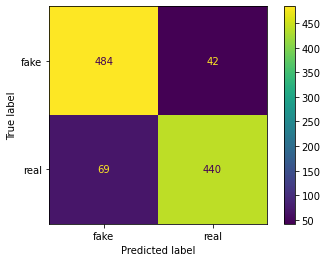

In [32]:
'''
Takes in lists of the true labels and model predictions,
then computes the precision, recall, and f1 score

'''
show_metrics(true_labels, model_preds)

Test loss: 0.4019, Test accuracy: 0.8783
Precision: 0.9031578947368422
Recall: 0.8428290766208252
F1 score: 0.8719512195121951


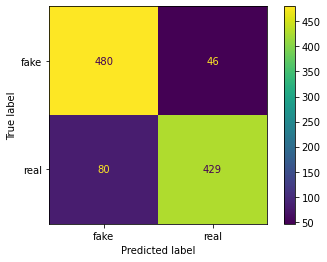

In [41]:
true_labels2, model_preds2, test_loss2, test_accuracy2 = test(device, model2, test_loader, autoencoder=autoencmodel, get_predictions=True)
show_metrics(true_labels2, model_preds2)

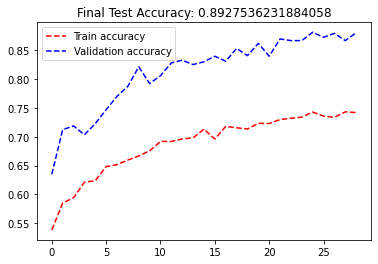

In [33]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

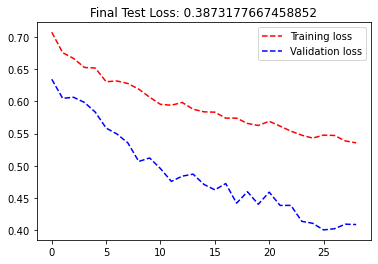

In [34]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

In [35]:
test_loader2 = produce_loader(test_data, 1)

In [36]:
"""
get_pictures_test

A simplified version of the test function that returns four lists
used for image visualization and confusion matrix computation.

Parameters:
device - device to use
model - model to train
data_loader - chosen (testing) data loader
autoencoder - autoencoder to use, if any (default is None)

Returns a list of correctly predicted images, a list of incorrectly predicted images, a list of true labels,
and a list of predictions made by the model each of length equal to the length of the data loader provided.

"""
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2, autoencmodel)

Precision: 0.6059027777777778
Recall: 0.6856581532416502
F1 score: 0.6433179723502304


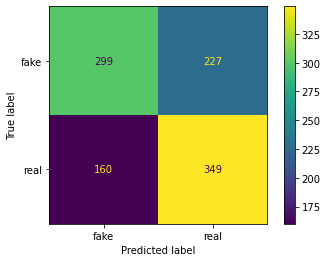

In [37]:
show_metrics(true_labels2, model_preds2)

[49, 365, 156, 635, 252, 212, 373, 12, 524, 272, 568, 533, 487, 309, 175, 166, 507, 441, 626, 312, 373, 629, 248, 388, 598]


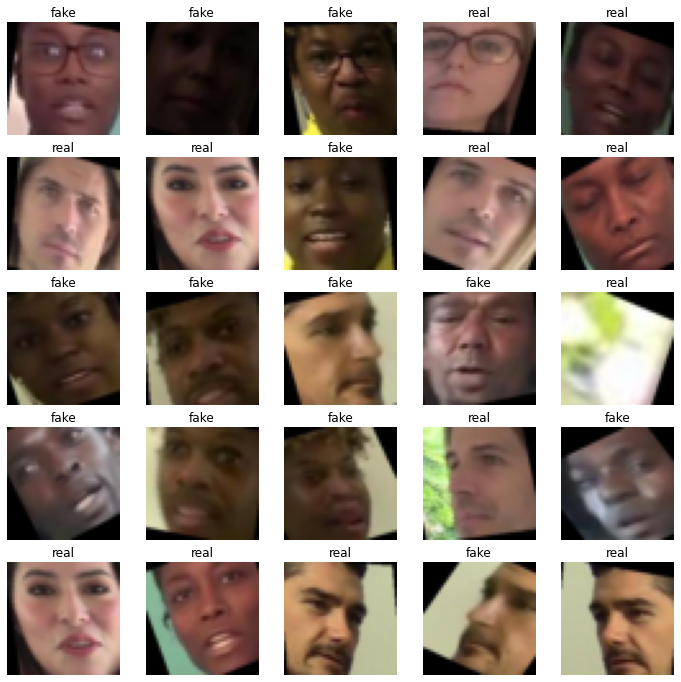

In [38]:
visualize_data(correct_list, (12,12), 5)

[110, 178, 120, 100, 378, 255, 358, 283, 375, 145, 377, 72, 244, 240, 220, 372, 74, 186, 349, 142, 213, 273, 174, 52, 138]


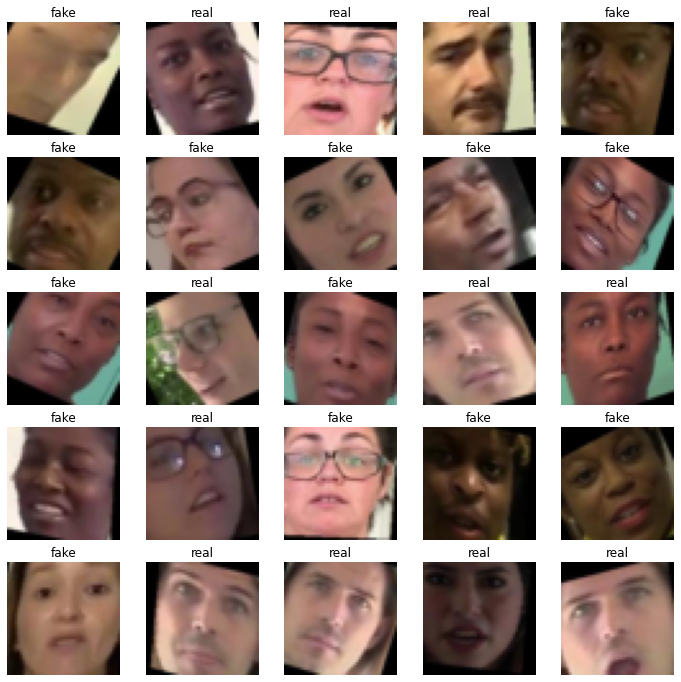

In [39]:
visualize_data(wrong_list, (12,12), 5)

## Saving Model

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './Transformer_10epochs_withAutoEncoder')

## Hyperparam tuning

Parameters that can be changed:

1) kernel_list

2) hidden_list - no. of neurons in each layer and no. of layers)

3) window_list - window size for max-pooling

4) blocks_list - no.of neurons in linear layers and no. of linear layers

5) dropout_list - probability for dropout layers

6) lr_list - learning rates for optimiser

In [24]:
from math import floor
# number of hidden layers and their sizes
hidden = [256, 256, 64, 32]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
channels = hidden[-1]
changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img
blocks = [flattened, 512, 64]

lr=0.01

lr_list=[0.01,0.005,0.001]

kernel_list=[3,5,7]

window_list=[2,3,5]

blocks_list=[[flattened, 512, 64], [flattened, 512, 256, 64], [flattened, 512, 128, 64]]

weight_decay=1e-5

hidden_list=[ [256, 256, 64, 32], [256,128,64,32]]

dropout_list=[0.3,0.5,0.7]

In [25]:
test_param="dropout"
test_losses = []
test_accuracies = []
precision_list=[]
recall_list=[]
f1_list=[]
epochs=10

for dropout in dropout_list:
    print(test_param+'='+str(dropout))
    new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
    channels = hidden[-1]
    changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )
    flattened = channels*changed_img*changed_img
    blocks[0]=flattened
    
    
    model = Transformer( hidden=hidden, kernel_size=kernel_size,
                  window=window, blocks=blocks,dropout=dropout).to(device)
    
    
   
    optimizer = create_adam_optimizer(model, lr=lr, weight_decay=weight_decay)
    
    tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = epochs, autoencoder=autoencmodel, checkpoint=False)
    true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, autoencoder=autoencmodel, get_predictions=True)
    p,r,f= return_metrics(true_labels, model_preds)
                           
    test_losses+=[test_loss]
    test_accuracies+=[test_accuracy]
    precision_list+=[p]
    recall_list+=[r]
    f1_list+=[f]

dropout=0.3
Epoch 1/10, Batch number: 0, Cumulated accuracy: 0.46875
Epoch 1/10, Batch number: 5, Cumulated accuracy: 0.54296875
Epoch 1/10, Batch number: 10, Cumulated accuracy: 0.6136363636363636
Epoch 1/10, Batch number: 15, Cumulated accuracy: 0.64111328125
Epoch 1/10, Batch number: 20, Cumulated accuracy: 0.6748511904761905
Epoch 1/10, Batch number: 25, Cumulated accuracy: 0.7049278846153846
Epoch 1/10, Batch number: 30, Cumulated accuracy: 0.7212701612903226
Epoch 1/10, Batch number: 35, Cumulated accuracy: 0.7335069444444444
Epoch 1/10, Batch number: 40, Cumulated accuracy: 0.7416158536585366
Epoch 1/10, Batch number: 45, Cumulated accuracy: 0.751358695652174
--- Epoch 1/10: Train loss: 0.5414, Train accuracy: 0.7524
--- Epoch 1/10: Val loss: 0.3218, Val accuracy: 0.8769
Epoch 2/10, Batch number: 0, Cumulated accuracy: 0.8984375
Epoch 2/10, Batch number: 5, Cumulated accuracy: 0.8463541666666666
Epoch 2/10, Batch number: 10, Cumulated accuracy: 0.8373579545454546
Epoch 2/10, Bat

Epoch 1/10, Batch number: 30, Cumulated accuracy: 0.5824092741935484
Epoch 1/10, Batch number: 35, Cumulated accuracy: 0.5935329861111112
Epoch 1/10, Batch number: 40, Cumulated accuracy: 0.6067073170731707
Epoch 1/10, Batch number: 45, Cumulated accuracy: 0.614639945652174
--- Epoch 1/10: Train loss: 0.6649, Train accuracy: 0.6160
--- Epoch 1/10: Val loss: 0.5088, Val accuracy: 0.7368
Epoch 2/10, Batch number: 0, Cumulated accuracy: 0.71875
Epoch 2/10, Batch number: 5, Cumulated accuracy: 0.6614583333333334
Epoch 2/10, Batch number: 10, Cumulated accuracy: 0.6803977272727273
Epoch 2/10, Batch number: 15, Cumulated accuracy: 0.6904296875
Epoch 2/10, Batch number: 20, Cumulated accuracy: 0.6964285714285714
Epoch 2/10, Batch number: 25, Cumulated accuracy: 0.7049278846153846
Epoch 2/10, Batch number: 30, Cumulated accuracy: 0.7129536290322581
Epoch 2/10, Batch number: 35, Cumulated accuracy: 0.7144097222222222
Epoch 2/10, Batch number: 40, Cumulated accuracy: 0.7221798780487805
Epoch 2/1

Epoch 2/10, Batch number: 0, Cumulated accuracy: 0.515625
Epoch 2/10, Batch number: 5, Cumulated accuracy: 0.5013020833333334
Epoch 2/10, Batch number: 10, Cumulated accuracy: 0.4872159090909091
Epoch 2/10, Batch number: 15, Cumulated accuracy: 0.4931640625
Epoch 2/10, Batch number: 20, Cumulated accuracy: 0.4914434523809524
Epoch 2/10, Batch number: 25, Cumulated accuracy: 0.4948918269230769
Epoch 2/10, Batch number: 30, Cumulated accuracy: 0.4891633064516129
Epoch 2/10, Batch number: 35, Cumulated accuracy: 0.4906684027777778
Epoch 2/10, Batch number: 40, Cumulated accuracy: 0.49447408536585363
Epoch 2/10, Batch number: 45, Cumulated accuracy: 0.49507472826086957
--- Epoch 2/10: Train loss: 0.6927, Train accuracy: 0.4966
--- Epoch 2/10: Val loss: 0.6708, Val accuracy: 0.7299
Epoch 3/10, Batch number: 0, Cumulated accuracy: 0.5390625
Epoch 3/10, Batch number: 5, Cumulated accuracy: 0.5104166666666666
Epoch 3/10, Batch number: 10, Cumulated accuracy: 0.4921875
Epoch 3/10, Batch number:

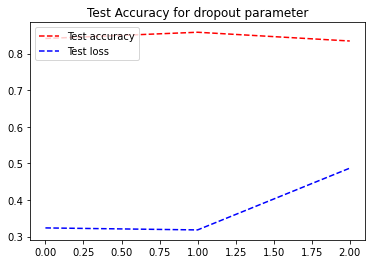

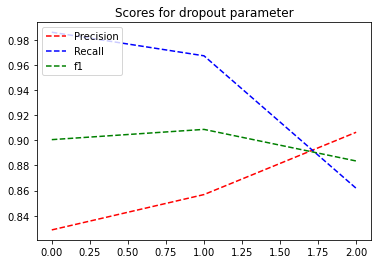

In [26]:
plt.plot(test_accuracies, "r--", label='Test accuracy')
plt.plot(test_losses, "b--", label='Test loss')
plt.title(f'Test Accuracy for {test_param} parameter')
plt.legend(loc='upper left')
plt.show()

plt.plot(precision_list, "r--", label='Precision')
plt.plot(recall_list, "b--", label='Recall')
plt.plot(f1_list, "g--", label='f1')
plt.title(f'Scores for {test_param} parameter')
plt.legend(loc='upper left')
plt.show()

In [27]:
print(f'test accuracy: {test_accuracies}')
print(f'test loss: {test_losses}')
print(f'precision: {precision_list}')
print(f'recall: {recall_list}')
print(f'f1 score: {f1_list}')

test accuracy: [0.841025641025641, 0.8581196581196581, 0.8341880341880342]
test loss: [0.32372383773326874, 0.31826016008853913, 0.48695518374443053]
precision: [0.8287401574803149, 0.8568464730290456, 0.9064039408866995]
recall: [0.9859484777517564, 0.9672131147540983, 0.8618266978922716]
f1 score: [0.9005347593582889, 0.9086908690869085, 0.8835534213685474]
